In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot, patches
from scipy import io
import numpy as np
from collections import defaultdict
import community
import pickle
from tqdm import tqdm
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import glob, os
import csv
import scipy.stats as st
from tabulate import tabulate

C:\Users\wyw25\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\wyw25\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# load the nullmodel data and structuralize

In [2]:
date="2018-01-31"
nulltype="EE"

In [3]:
def Make_dict_of_type(date,nulltype): #200*200=40000
    N_MODEL_dic={}
    Q_MODEL_dic={}
    I_MODEL_dic={}
    I_MQ_MODEL_dic={}
    for i in tqdm(range(200)):  # index for nullmodel
        N_dic={}
        Q_dic={}
        I_dic={}
        I_MQ_dic={}
        for j in range(200): # repeat times
            Address="C:/Users/wyw25/thesis/"+date+"_OUTPUT/"+nulltype+"/"+str(i)+"_nullindex/"+str(j)+"_repeat/data_structures_NQI_results"+date+".csv"
            df_output=pd.read_csv(Address)
            N_dic[j]=df_output['N'].values[0]
            Q_dic[j]=df_output['Q'].values[0]
            I_dic[j]=df_output['I'].values[0]
            I_MQ_dic[j]=df_output['I_MQ'].values[0]
        
        N_MODEL_dic[i]=N_dic
        Q_MODEL_dic[i]=Q_dic
        I_MODEL_dic[i]=I_dic
        I_MQ_MODEL_dic[i]=I_MQ_dic
        
    return  N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic
               

In [4]:
def Make_dict_of_date(date):
    EE={}
    FF={}
    PEEP={}
    PP={}
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"EE")
    EE['N']=N_MODEL_dic
    EE['Q']=Q_MODEL_dic
    EE['I']=I_MODEL_dic
    EE['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"FF")
    FF['N']=N_MODEL_dic
    FF['Q']=Q_MODEL_dic
    FF['I']=I_MODEL_dic
    FF['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"PEEP")
    PEEP['N']=N_MODEL_dic
    PEEP['I']=I_MODEL_dic
    PEEP['Q']=Q_MODEL_dic
    PEEP['I_MQ']=I_MQ_MODEL_dic
    
    N_MODEL_dic,  Q_MODEL_dic, I_MODEL_dic, I_MQ_MODEL_dic=Make_dict_of_type(date,"PP")
    PP['N']=N_MODEL_dic
    PP['Q']=Q_MODEL_dic
    PP['I']=I_MODEL_dic
    PP['I_MQ']=I_MQ_MODEL_dic
    
    
    return EE,FF,PEEP,PP
    
    

In [5]:
EE,FF,PEEP,PP=Make_dict_of_date("2018-01-31")

 16%|████████████▌                                                                    | 31/200 [00:43<03:59,  1.42s/it]


KeyboardInterrupt: 

# load the empirical data and structuralize

In [ ]:
def Make_Empricial_data(date):
    N_dic={}
    Q_dic={}
    I_dic={}
    I_MQ_dic={}
    for i in range(200): # repeat times
        Address="C:/Users/wyw25/thesis/"+date+"/"+str(i)+"/data_structures_NQI_results"+date+".csv"
        df_output=pd.read_csv(Address)
        N_dic[i]=df_output['N'].values[0]
        Q_dic[i]=df_output['Q'].values[0]
        I_dic[i]=df_output['I'].values[0]
        I_MQ_dic[i]=df_output['I_MQ'].values[0]
            
    return  list(N_dic.values()),  list(Q_dic.values()), list(I_dic.values()), list(I_MQ_dic.values())

In [ ]:
N_em,  Q_em, I_em, I_MQ_em=Make_Empricial_data("2018-01-31")

# Load data from server

In [20]:
datelist=['2018-01-16','2018-01-17',
            '2018-01-18','2018-01-19','2018-01-20','2018-01-21','2018-01-22','2018-01-23','2018-01-24',
            '2018-01-25','2018-01-26','2018-01-27','2018-01-28','2018-01-29','2018-01-30','2018-01-31', 
            '2018-02-01','2018-02-02','2018-02-03','2018-02-04','2018-02-05','2018-02-06','2018-02-07']

In [7]:
DATA_NULL={}
for date in datelist:
    with open("C:/Users/wyw25/thesis/to_local/"+date+"_stat.pkl", 'rb') as fp:
        parameters= pickle.load(fp)    
    DATA_NULL[date]=parameters

In [8]:
def Date_Slice_data(date,D):
    EE=D[date]['EE']
    FF=D[date]['FF']
    PEEP=D[date]['PEEP']
    PP=D[date]['PP']
    
    return EE,FF,PEEP,PP
    

In [9]:
DATA_EM={}
for date in datelist:
    with open("C:/Users/wyw25/thesis/em_to_local/"+date+"_stat.pkl", 'rb') as fp:
        parameters= pickle.load(fp)    
    DATA_EM[date]=parameters

In [10]:
def Date_Slice_EM(date,D):
    N_em=D[date]['N_em']
    Q_em=D[date]['Q_em']
    I_em=D[date]['I_em']
    I_MQ_em=D[date]['I_MQ_em']
    
    return N_em,  Q_em, I_em, I_MQ_em

# the functions for visualization

In [11]:
def Make_Gross_list(typedict):
    Gross_list=[]
    for variables in ['N','I','Q','I_MQ']: 
        numbers=[]
        for repeat in typedict[variables].keys():
            numbers=numbers+list(typedict[variables][repeat].values())
        Gross_list.append(numbers)   
            
    return Gross_list[0],Gross_list[1],Gross_list[2],Gross_list[3]
        

In [12]:
def Draw_means(data,position,Color,Label):
    sample_means = np.mean(data, axis=1)

    # Create a violin plot with the roles of x and y switched
    bp=plt.violinplot(data, showmeans=True, showextrema=False,positions=position,  widths=0.4)

    # Add a vertical line or point for the mean of each sample
    for i, mean_val in enumerate(sample_means):
        plt.plot(position[i], mean_val, 'k.')  # 'ro' stands for red color, round marker
        plt.text(position[i], mean_val+0.1,  "{:.2f}".format(mean_val), color='black', ha='center',fontsize=7)
        
    set_box_color(bp, Color)     
    
    return plt

In [13]:
def set_box_color(bp, color):
      #  plt.setp(bp['boxes'], color=color)
      #  plt.setp(bp['whiskers'], color=color)
       # plt.setp(bp['caps'], color=color)
       # plt.setp(bp['medians'], color=color)
    plt.setp(bp['bodies'], color=color)

def MAKE_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):    
    plt.figure(figsize=(6,4))

    bp1 = Draw_means(dataEE,np.array(range(len(dataEE)))*3.0-1.0,'tab:blue','EE')
    bp2 = Draw_means(dataFF,np.array(range(len(dataFF)))*3.0-0.5,'tab:orange','FF')
    bp3 = Draw_means(dataPEEP,np.array(range(len(dataPEEP)))*3.0,'tab:green','PEEP')
    bp4 = Draw_means(dataPP,np.array(range(len(dataPP)))*3.0+0.5,'tab:brown','PP')
    bp5 = Draw_means(dataEMPIRICAL,np.array(range(len(dataPP)))*3.0+1.0,'red','Empirical')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    #plt.xlim(-2, len(ticks)*3)
    plt.ylim(0, 1)
    plt.tight_layout()

In [14]:
def Make_Plot_Of_Day(date,DATA_NULL,DATA_EM):
    # load the data on one day
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)

    # make list by types of nullmodel
    dataEE=[N_EE,I_EE,Q_EE,I_MQ_EE]
    dataFF=[N_FF,I_FF,Q_FF,I_MQ_FF]
    dataPEEP=[N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP]
    dataPP=[N_PP,I_PP,Q_PP,I_MQ_PP]
    dataEMPIRICAL=[N_em,I_em,Q_em,I_MQ_em]

    ticks_NULL=['N','I','Q','I_MQ']

    # make list by types of indexs
    dataN=[N_EE,N_FF,N_PEEP,N_PP,N_em]
    dataI=[I_EE,I_FF,I_PEEP,I_PP,I_em]
    dataQ=[Q_EE,Q_FF,Q_PEEP,Q_PP,Q_em]
    dataIMQ=[I_MQ_EE,I_MQ_FF,I_MQ_PEEP,I_MQ_PP,I_MQ_em]

    ticks_INDEX=['EE','FF','PEEP','PP','EMPIRICAL']

    MAKE_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)



# Z and P values

In [15]:
def Z_P_score(list_em,list_null):
    n_em=len(list_em)
    n_null=len(list_null)
    em_bar=np.mean(list_em)
    null_bar=np.mean(list_null)
    em_std=np.std(list_em)
    null_std=np.std(list_null)
    
    z_scores=(em_bar-null_bar)/ (np.sqrt(null_std*null_std/n_null+em_std*em_std/n_em))
    p_values = st.norm.sf(abs(z_scores)) #one-sided
    
    return z_scores,p_values
    

In [16]:
def Make_Stat_Values(date,DATA_NULL,DATA_EM):
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)

    z_N_EE,p_N_EE=Z_P_score(N_em,N_EE)
    z_N_FF,p_N_FF=Z_P_score(N_em,N_FF)
    z_N_PEEP,p_N_PEEP=Z_P_score(N_em,N_PEEP)
    z_N_PP,p_N_PP=Z_P_score(N_em,N_PP)

    z_Q_EE,p_Q_EE=Z_P_score(Q_em,Q_EE)
    z_Q_FF,p_Q_FF=Z_P_score(Q_em,Q_FF)
    z_Q_PEEP,p_Q_PEEP=Z_P_score(Q_em,Q_PEEP)
    z_Q_PP,p_Q_PP=Z_P_score(Q_em,Q_PP)

    z_I_EE,p_I_EE=Z_P_score(I_em,I_EE)
    z_I_FF,p_I_FF=Z_P_score(I_em,I_FF)
    z_I_PEEP,p_I_PEEP=Z_P_score(I_em,I_PEEP)
    z_I_PP,p_I_PP=Z_P_score(I_em,I_PP)

    z_I_MQ_EE,p_I_MQ_EE=Z_P_score(I_MQ_em,I_MQ_EE)
    z_I_MQ_FF,p_I_MQ_FF=Z_P_score(I_MQ_em,I_MQ_FF)
    z_I_MQ_PEEP,p_I_MQ_PEEP=Z_P_score(I_MQ_em,I_MQ_PEEP)
    z_I_MQ_PP,p_I_MQ_PP=Z_P_score(I_MQ_em,I_MQ_PP)
    
    
    variable_names = ['N_EE', 'N_FF', 'N_PEEP', 'N_PP',
                  'Q_EE', 'Q_FF', 'Q_PEEP', 'Q_PP',
                  'I_EE', 'I_FF', 'I_PEEP', 'I_PP',
                  'I_MQ_EE', 'I_MQ_FF', 'I_MQ_PEEP', 'I_MQ_PP']

    
    z_scores = [z_N_EE, z_N_FF, z_N_PEEP, z_N_PP,
            z_Q_EE, z_Q_FF, z_Q_PEEP, z_Q_PP,
            z_I_EE, z_I_FF, z_I_PEEP, z_I_PP,
            z_I_MQ_EE, z_I_MQ_FF, z_I_MQ_PEEP, z_I_MQ_PP]

    p_values = [p_N_EE, p_N_FF, p_N_PEEP, p_N_PP,
            p_Q_EE, p_Q_FF, p_Q_PEEP, p_Q_PP,
            p_I_EE, p_I_FF, p_I_PEEP, p_I_PP,
            p_I_MQ_EE, p_I_MQ_FF, p_I_MQ_PEEP, p_I_MQ_PP]

   
    return   z_scores, p_values

In [17]:
z_scores={}
p_values={}
for date in datelist:
     z_scores[date], p_values[date]=Make_Stat_Values(date,DATA_NULL,DATA_EM)
    

In [18]:
z_N_EE=np.array(list(z_scores.values()))[:,0]
z_N_FF=np.array(list(z_scores.values()))[:,1]
z_N_PEEP=np.array(list(z_scores.values()))[:,2]
z_N_PP=np.array(list(z_scores.values()))[:,3]
z_Q_EE=np.array(list(z_scores.values()))[:,4]
z_Q_FF=np.array(list(z_scores.values()))[:,5]
z_Q_PEEP=np.array(list(z_scores.values()))[:,6]
z_Q_PP=np.array(list(z_scores.values()))[:,7]
z_I_EE=np.array(list(z_scores.values()))[:,8]
z_I_FF=np.array(list(z_scores.values()))[:,9]
z_I_PEEP=np.array(list(z_scores.values()))[:,10]
z_I_PP=np.array(list(z_scores.values()))[:,11]
z_I_MQ_EE=np.array(list(z_scores.values()))[:,12]
z_I_MQ_FF=np.array(list(z_scores.values()))[:,13]
z_I_MQ_PEEP=np.array(list(z_scores.values()))[:,14]
z_I_MQ_PP=np.array(list(z_scores.values()))[:,15]

p_N_EE=np.array(list(p_values.values()))[:,0]
p_N_FF=np.array(list(p_values.values()))[:,1]
p_N_PEEP=np.array(list(p_values.values()))[:,2]
p_N_PP=np.array(list(p_values.values()))[:,3]
p_Q_EE=np.array(list(p_values.values()))[:,4]
p_Q_FF=np.array(list(p_values.values()))[:,5]
p_Q_PEEP=np.array(list(p_values.values()))[:,6]
p_Q_PP=np.array(list(p_values.values()))[:,7]
p_I_EE=np.array(list(p_values.values()))[:,8]
p_I_FF=np.array(list(p_values.values()))[:,9]
p_I_PEEP=np.array(list(p_values.values()))[:,10]
p_I_PP=np.array(list(p_values.values()))[:,11]
p_I_MQ_EE=np.array(list(p_values.values()))[:,12]
p_I_MQ_FF=np.array(list(p_values.values()))[:,13]
p_I_MQ_PEEP=np.array(list(p_values.values()))[:,14]
p_I_MQ_PP=np.array(list(p_values.values()))[:,15]



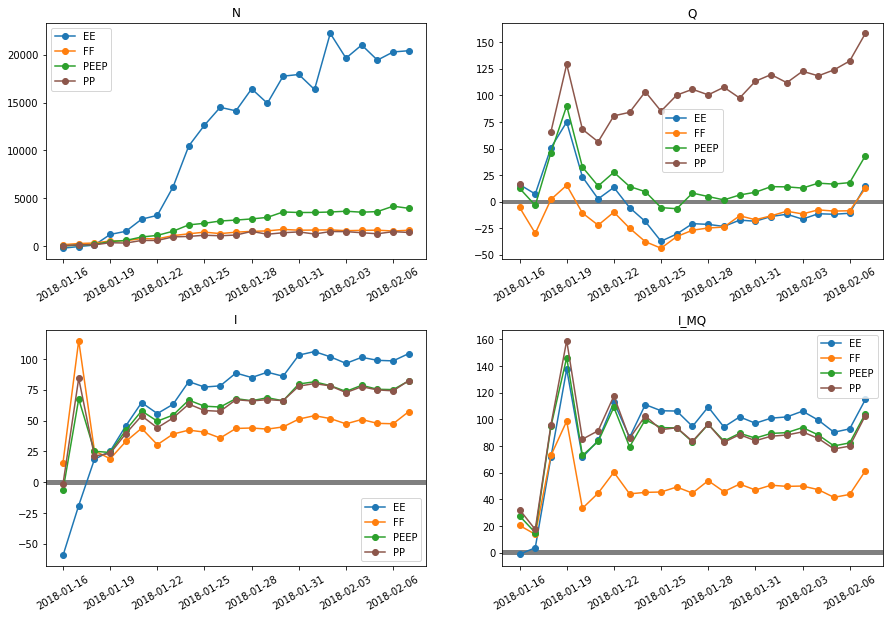

In [55]:
labels=datelist
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axs[0, 0].plot(z_N_EE,'o-', color='tab:blue')
axs[0, 0].plot(z_N_FF, 'o-', color='tab:orange')
axs[0, 0].plot(z_N_PEEP,'o-', color='tab:green')
axs[0, 0].plot(z_N_PP, 'o-', color='tab:brown')
axs[0, 0].axhspan(-2, 2, facecolor='0.5')
axs[0, 0].set_title('N')
#axs[0, 0].set_ylim(0,8000)

axs[0, 1].plot(z_Q_EE, 'o-', color='tab:blue')
axs[0, 1].plot(z_Q_FF, 'o-', color='tab:orange')
axs[0, 1].plot(z_Q_PEEP, 'o-', color='tab:green')
axs[0, 1].plot(z_Q_PP,  'o-',color='tab:brown')
axs[0, 1].axhspan(-2, 2, facecolor='0.5')
axs[0, 1].set_title('Q')


axs[1, 0].plot(z_I_EE, 'o-', color='tab:blue')
axs[1, 0].plot(z_I_FF, 'o-', color='tab:orange')
axs[1, 0].plot(z_I_PEEP, 'o-', color='tab:green')
axs[1, 0].plot(z_I_PP, 'o-', color='tab:brown')
axs[1, 0].axhspan(-2, 2, facecolor='0.5')
axs[1, 0].set_title('I')

axs[1, 1].plot(z_I_MQ_EE,'o-',  color='tab:blue')
axs[1, 1].plot(z_I_MQ_FF, 'o-', color='tab:orange')
axs[1, 1].plot(z_I_MQ_PEEP,'o-',  color='tab:green')
axs[1, 1].plot(z_I_MQ_PP, 'o-',color='tab:brown')
axs[1, 1].axhspan(-2, 2, facecolor='0.5')
axs[1, 1].set_title('I_MQ')

for ax in axs.flat:
    ax.legend(['EE', 'FF', 'PEEP','PP'])
#    ax.set_xticks(np.arange(0, len(labels) ), labels=labels,rotation=30)
#    ax.set_yticklabels([])
    ax.set_xticks(np.arange(0, len(labels), step=3))
    ax.set_xticklabels(labels[::3], rotation=30)

fig.subplots_adjust(hspace=0.3)
plt.show()

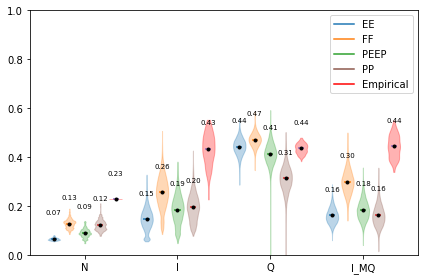

In [29]:
Make_Plot_Of_Day('2018-01-23',DATA_NULL,DATA_EM)

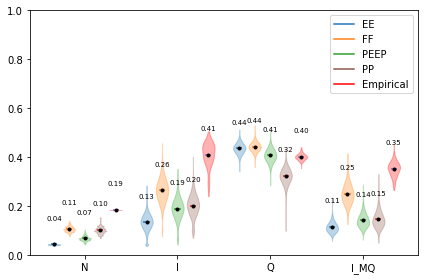

In [30]:
Make_Plot_Of_Day('2018-01-25',DATA_NULL,DATA_EM)

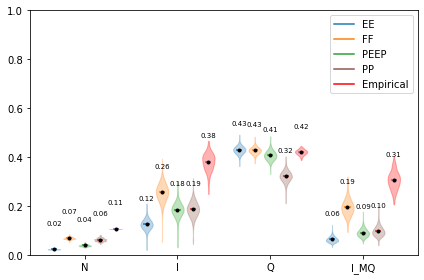

In [31]:
Make_Plot_Of_Day('2018-02-05',DATA_NULL,DATA_EM)

# Make Time Series

In [32]:
def Make_One_Day(date,DATA_NULL,DATA_EM):
    # load the data on one day
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em,  Q_em, I_em, I_MQ_em=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE,I_EE,Q_EE,I_MQ_EE=Make_Gross_list(EE)
    N_FF,I_FF,Q_FF,I_MQ_FF=Make_Gross_list(FF)
    N_PEEP,I_PEEP,Q_PEEP,I_MQ_PEEP=Make_Gross_list(PEEP)
    N_PP,I_PP,Q_PP,I_MQ_PP=Make_Gross_list(PP)
    
    

In [33]:
N_em={}
Q_em={}
I_em={}
I_MQ_em={}
N_EE={}
I_EE={}
Q_EE={}
I_MQ_EE={}
N_FF={}
I_FF={}
Q_FF={}
I_MQ_FF={}
N_PEEP={}
I_PEEP={}
Q_PEEP={}
I_MQ_PEEP={}
N_PP={}
I_PP={}
Q_PP={}
I_MQ_PP={}

for date in datelist:
    
    EE,FF,PEEP,PP=Date_Slice_data(date,DATA_NULL)
    N_em[date],  Q_em[date], I_em[date], I_MQ_em[date]=Date_Slice_EM(date,DATA_EM) 

    # make gross list of the date
    N_EE[date],I_EE[date],Q_EE[date],I_MQ_EE[date]=Make_Gross_list(EE)
    N_FF[date],I_FF[date],Q_FF[date],I_MQ_FF[date]=Make_Gross_list(FF)
    N_PEEP[date],I_PEEP[date],Q_PEEP[date],I_MQ_PEEP[date]=Make_Gross_list(PEEP)
    N_PP[date],I_PP[date],Q_PP[date],I_MQ_PP[date]=Make_Gross_list(PP)
    

In [34]:
# THE GRAPH BY TIME

In [35]:
def Draw_means_LINE(data,position,Color,Label):
    sample_means = np.mean(data, axis=1)

    # Create a violin plot with the roles of x and y switched
    bp=plt.violinplot(data, showmeans=True, showextrema=False,positions=position,  widths=0.4)

    # Add a vertical line or point for the mean of each sample
    for i, mean_val in enumerate(sample_means):
        plt.plot(position[i], mean_val, 'k.')  # 'ro' stands for red color, round marker
        plt.text(position[i], mean_val+0.1,  "{:.2f}".format(mean_val), color='black', ha='center',fontsize=7)
    plt.plot(position, sample_means, color=Color)
        
    set_box_color(bp, Color)     
    
    return plt

In [56]:
def MAKE_time_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):    
    plt.figure(figsize=(16,4))

    bp1 = Draw_means_LINE(dataEE,np.array(range(len(dataEE)))*3.0-1.0,'tab:blue','EE')
    bp2 = Draw_means_LINE(dataFF,np.array(range(len(dataFF)))*3.0-0.5,'tab:orange','FF')
    bp3 = Draw_means_LINE(dataPEEP,np.array(range(len(dataPEEP)))*3.0,'tab:green','PEEP')
    bp4 = Draw_means_LINE(dataPP,np.array(range(len(dataPP)))*3.0+0.5,'tab:brown','PP')
    bp5 = Draw_means_LINE(dataEMPIRICAL,np.array(range(len(dataPP)))*3.0+1.0,'red','Empirical')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='tab:blue', label='EE')
    plt.plot([], c='tab:orange', label='FF')
    plt.plot([], c='tab:green', label='PEEP')
    plt.plot([], c='tab:brown', label='PP')
    plt.plot([], c='red', label='Empirical')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 3, 3), ticks,rotation=30)
    #plt.xlim(-2, len(ticks)*3)
    plt.ylim(0, 1)
    #plt.figure(figsize=(20,4))
    #plt.rcParams["figure.figsize"] = (20,3)
    plt.tight_layout()

In [37]:
def Make_Time_Visualization(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10,12), sharey=True)
    axs[0].set_ylabel('EE')
    parts = axs[0].violinplot(dataEE, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:blue')
        pc.set_edgecolor('tab:blue')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataEE, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[0].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[0].plot(inds, sample_means, marker='.', color='tab:blue')


    axs[1].set_ylabel('FF')
    parts = axs[1].violinplot(dataFF, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:orange')
        pc.set_edgecolor('tab:orange')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataFF, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[1].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[1].plot(inds, sample_means, marker='.', color='tab:orange')

    axs[2].set_ylabel('PEEP')
    parts = axs[2].violinplot(dataPEEP, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:green')
        pc.set_edgecolor('tab:green')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataPEEP, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[2].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[2].plot(inds, sample_means, marker='.', color='tab:green')


    axs[3].set_ylabel('PP')
    parts = axs[3].violinplot(dataPP, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:brown')
        pc.set_edgecolor('tab:brown')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataPP, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[3].scatter(inds, sample_means, marker='.', color='k', s=30, zorder=3)
    axs[3].plot(inds, sample_means, marker='.', color='tab:brown')


    axs[4].set_ylabel('Empirical')
    parts = axs[4].violinplot(dataEMPIRICAL, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
        pc.set_alpha(0.5)

    sample_means = np.mean(dataEMPIRICAL, axis=1)
    inds = np.arange(1, len(sample_means) + 1)
    axs[4].scatter(inds, sample_means, marker='.', color='k', s=20, zorder=3)
    axs[4].plot(inds, sample_means, marker='.', color='red')

    for ax in axs:
        ax.set_xticks(np.arange(1, len(ticks) + 1), labels=ticks,rotation=30)
        ax.set_ylim(0,1)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [38]:
def Stat_Time(EE,FF,PEEP,PP,em):
    dataEE=list(EE.values())
    dataFF=list(FF.values())
    dataPEEP=list(PEEP.values())
    dataPP=list(PP.values())
    dataEMPIRICAL=list(em.values())

    ticks_NULL=datelist
            
    MAKE_time_violin(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)
    Make_Time_Visualization(dataEE,dataFF,dataPEEP,dataPP,dataEMPIRICAL,ticks_NULL)

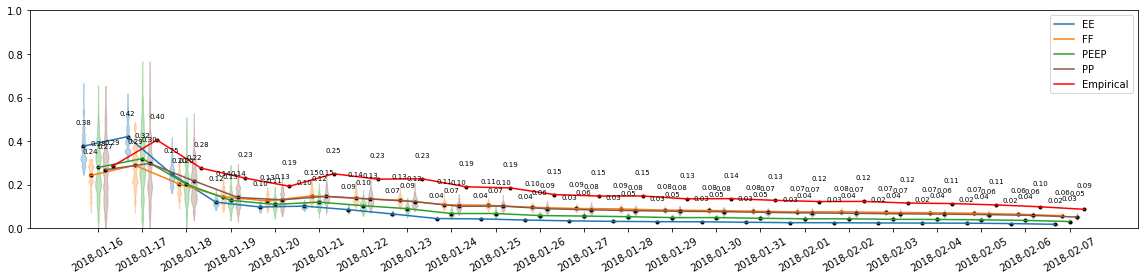

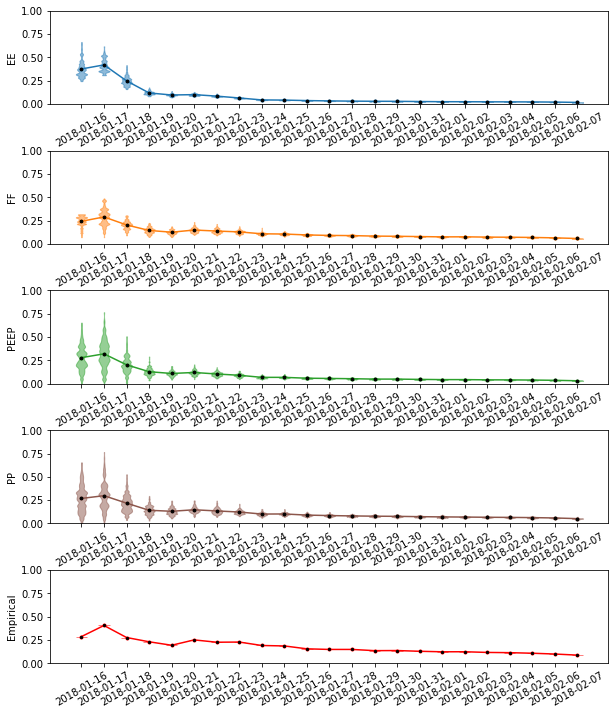

In [57]:
# NODF
# SAME OF ALL RANDOM
Stat_Time(N_EE,N_FF,N_PEEP,N_PP,N_em)


C:\Users\wyw25\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\wyw25\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
posx and posy should be finite values
posx and posy should be finite values


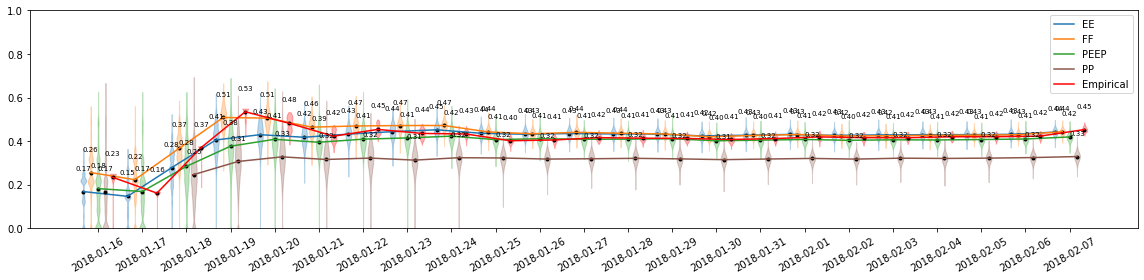

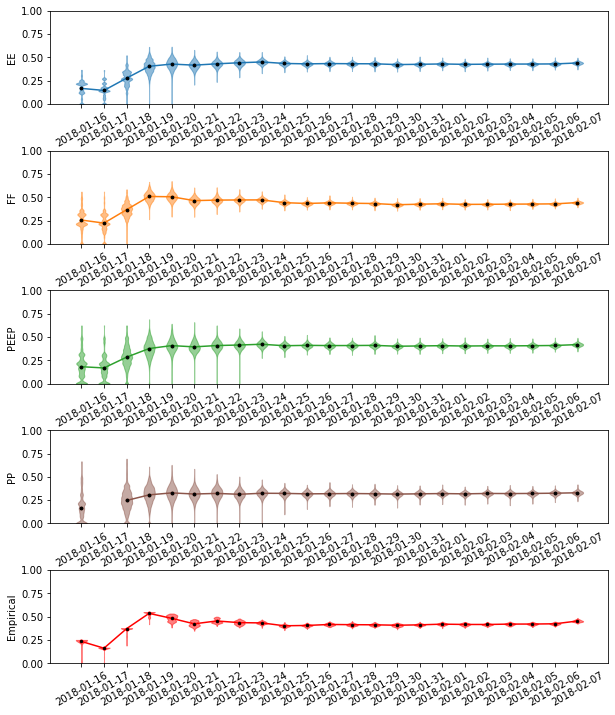

In [58]:
# Modularity
Stat_Time(Q_EE,Q_FF,Q_PEEP,Q_PP,Q_em)
    

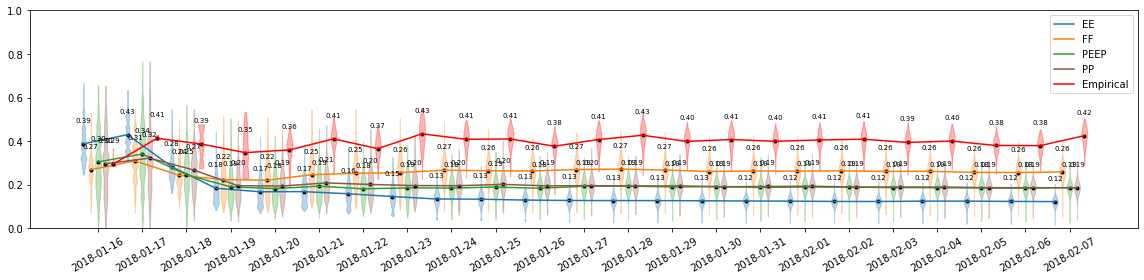

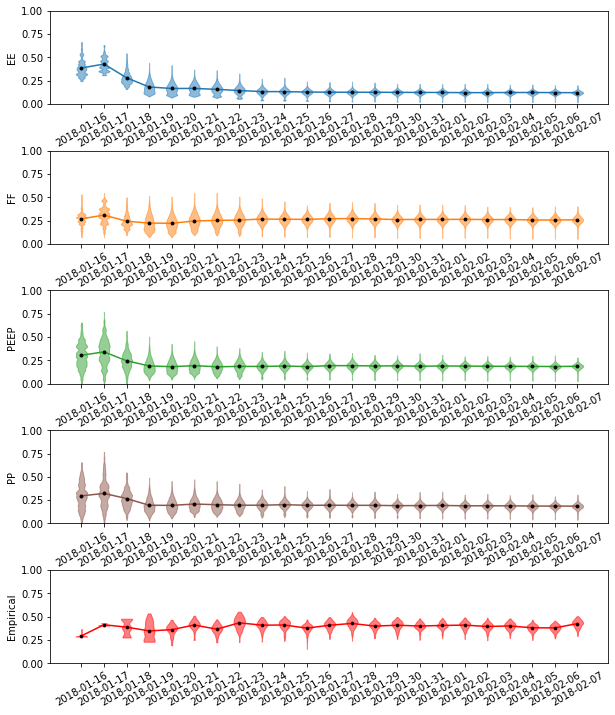

In [59]:
# Inblock Nestedness
Stat_Time(I_EE,I_FF,I_PEEP,I_PP,I_em)    


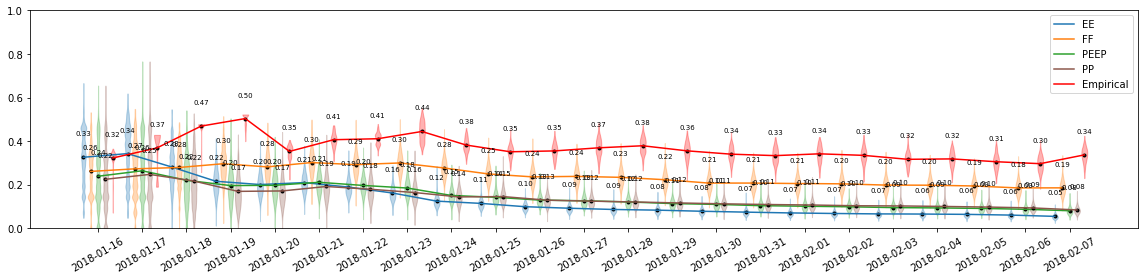

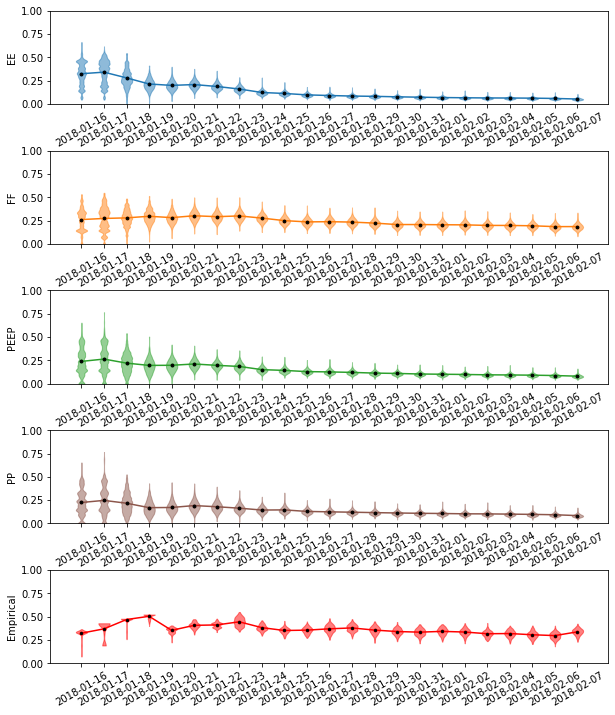

In [60]:
# Inblock Nestedness under Max Modularity
Stat_Time(I_MQ_EE,I_MQ_FF,I_MQ_PEEP,I_MQ_PP,I_MQ_em)


In [ ]:
# 200 for each null models 

In [ ]:
# repeat 200 for each